# CS 5864: Homework 2, Part 4 - Single-View Metrology

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces. In [main function](#Main-function), we outline the required functionalities step by step. Some of the functions which involves interactive plots are already provided, but [the rest](#Your-implementation) are left for you to implement. Credits to Derek Hoiem for starter code.

## Package installation
- In this code, we use some `tkinter` package. Installation instruction can be found [here](https://anaconda.org/anaconda/tk).

# Common imports

In [2]:
%matplotlib tk
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

# Provided functions

In [3]:
def get_input_lines(im, min_lines=3):
    """
    Allows user to input line segments; computes centers and directions.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        min_lines: minimum number of lines required
    Returns:
        n: number of lines from input
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        centers: np.ndarray of shape (3, n)
            where each column denotes the homogeneous coordinates of the centers
    """
    n = 0
    lines = np.zeros((3, 0))
    centers = np.zeros((3, 0))

    plt.figure()
    plt.imshow(im)
    plt.show()
    print('Set at least %d lines to compute vanishing point' % min_lines)
    while True:
        print('Click the two endpoints, use the right key to undo, and use the middle key to stop input')
        clicked = plt.ginput(2, timeout=0, show_clicks=True)
        if not clicked or len(clicked) < 2:
            if n < min_lines:
                print('Need at least %d lines, you have %d now' % (min_lines, n))
                continue
            else:
                # Stop getting lines if number of lines is enough
                break

        # Unpack user inputs and save as homogeneous coordinates
        pt1 = np.array([clicked[0][0], clicked[0][1], 1])
        pt2 = np.array([clicked[1][0], clicked[1][1], 1])
        # Get line equation using cross product
        # Line equation: line[0] * x + line[1] * y + line[2] = 0
        line = np.cross(pt1, pt2)
        lines = np.append(lines, line.reshape((3, 1)), axis=1)
        # Get center coordinate of the line segment
        center = (pt1 + pt2) / 2
        centers = np.append(centers, center.reshape((3, 1)), axis=1)

        # Plot line segment
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='b')

        n += 1

    return n, lines, centers

In [4]:
def plot_lines_and_vp(im, lines, vp):
    """
    Plots user-input lines and the calculated vanishing point.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        lines: np.ndarray of shape (3, n)
            where each column denotes the parameters of the line equation
        vp: np.ndarray of shape (3, )
    """
    bx1 = min(1, vp[0] / vp[2]) - 10
    bx2 = max(im.shape[1], vp[0] / vp[2]) + 10
    by1 = min(1, vp[1] / vp[2]) - 10
    by2 = max(im.shape[0], vp[1] / vp[2]) + 10

    plt.figure()
    plt.imshow(im)
    for i in range(lines.shape[1]):
        if lines[0, i] < lines[1, i]:
            pt1 = np.cross(np.array([1, 0, -bx1]), lines[:, i])
            pt2 = np.cross(np.array([1, 0, -bx2]), lines[:, i])
        else:
            pt1 = np.cross(np.array([0, 1, -by1]), lines[:, i])
            pt2 = np.cross(np.array([0, 1, -by2]), lines[:, i])
        pt1 = pt1 / pt1[2]
        pt2 = pt2 / pt2[2]
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'g')

    plt.plot(vp[0] / vp[2], vp[1] / vp[2], 'ro')
    plt.show()

In [5]:
def get_top_and_bottom_coordinates(im, obj):
    """
    For a specific object, prompts user to record the top coordinate and the bottom coordinate in the image.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        obj: string, object name
    Returns:
        coord: np.ndarray of shape (3, 2)
            where coord[:, 0] is the homogeneous coordinate of the top of the object and coord[:, 1] is the homogeneous
            coordinate of the bottom
    """
    plt.figure()
    plt.imshow(im)

    print('Click on the top coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x1, y1 = clicked[0]
    # Uncomment this line to enable a vertical line to help align the two coordinates
    # plt.plot([x1, x1], [0, im.shape[0]], 'b')
    print('Click on the bottom coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x2, y2 = clicked[0]

    plt.plot([x1, x2], [y1, y2], 'b')

    return np.array([[x1, x2], [y1, y2], [1, 1]])

# Your implementation

In [6]:
import itertools
def get_vanishing_point(lines, centers):
    """
    Solves for the vanishing point using the user-input lines.
    """
    # <YOUR IMPLEMENTATION>
    ### 
    # lines.shape = [[a1, a2, a3],
    #                [b1, b2, b3],
    #                [c1, c2, c3]]
    ###

    n = lines.shape[0]
    candidates = []

    for i, j in itertools.combinations(range(n), 2):
        v = np.cross(lines[:, i], lines[:, j])
        v /= v[2]
        candidates.append(v)
    
    def compute_angle(l):
        a, b, c = l
        return np.arctan2(-a, b)
    
    scores = []
    for p in candidates:
        s = 0
        for i in range(n):
            th_i = compute_angle(lines[:, i])
            c_i = centers[:, i]
            al_i = np.arctan2(v[1] - c_i[1], v[0] - c_i[0])
            diff = np.abs((al_i - th_i + np.pi) % (2 * np.pi) - np.pi)
            length = np.linalg.norm(lines[:2, i])
            s += length * np.exp(- (diff ** 2) / (2 * 0.1 ** 2))
        scores.append((v, s))

    v_f, s_f = max(scores, key=lambda x: x[1])

    # A = lines.T
    # U, s, Vt = np.linalg.svd(A)
    # vp = Vt[-1, :]
    
    return v_f
    # pass

In [7]:
def get_horizon_line(vx, vy):
    """
    Calculates the ground horizon line.
    """
    # <YOUR IMPLEMENTATION>
    l = np.cross(vx, vy)
    return l
    # pass

In [8]:
import math
def plot_horizon_line(lg, im):
    """
    Plots the horizon line.
    """
    # <YOUR IMPLEMENTATION>
    a, b, c = lg

    d = math.sqrt(a ** 2 + b ** 2)

    a /= d
    b /= d
    c /= d

    print(f"{a:.4f}x + {b:.4f}y + {c:.4f} = 0")
    # im = np.array(im)
    h, w, cc = im.shape

    x1 = 0
    x2 = w

    y1 = -c / b
    y2 = -(x2 * a + c)/b
    plt.figure()
    plt.imshow(im)
    plt.plot([x1, x2], [y1, y2], color='r', linewidth=2)
    plt.show()
    # pass

In [ ]:
import sympy

def get_camera_parameters(vps):
    """
    Computes the camera parameters. Hint: The SymPy package is suitable for this.
    """
    # <YOUR IMPLEMENTATION>
    
    f, u, v = sympy.symbols('f u v')

    K = sympy.Matrix([[f, 0, u],
         [0, f, v],
         [0, 0, 1]])
    
    vx = sympy.Matrix(vps[0])
    vy = sympy.Matrix(vps[1])
    vz = sympy.Matrix(vps[2])
    m = K.inv().T * K.inv()
    # convert vp in 2d corroeidinate to 3d
    eq1 = sympy.Eq((vx.T * m * vy)[0], 0)
    eq2 = sympy.Eq((vy.T * m * vz)[0], 0)
    eq3 = sympy.Eq((vz.T * m * vx)[0], 0)

    s = sympy.solve([eq1, eq2, eq3], [f, u, v])


    return s[f], s[u], s[v]
    # pass

In [10]:
def get_rotation_matrix(f, u, v, vps):
    """
    Computes the rotation matrix using the camera parameters.
    """
    # <YOUR IMPLEMENTATION>
    vx = vps[:, 0]
    vy = vps[:, 2]
    vz = vps[:, 1]

    K = np.array([[f, 0, u],
         [0, f, v],
         [0, 0, 1]], dtype=float)
#     print(K.dtype)
    
    k_inv = np.linalg.inv(K)
    diretions = [k_inv @ v for v in [vx, vy, vz]]
    diretions = [d / np.linalg.norm(d) for d in diretions]

    R = np.column_stack(diretions)

    U, v, Vt = np.linalg.svd(R)

    R = U @ Vt

    return R

In [12]:
def estimate_height(line, t0, b0, t1, b1, h=1.65):
    """
    Estimates height for a specific object using the recorded coordinates. You might need to plot additional images here for
    your report.
    """
    # <YOUR IMPLEMENTATION>
    lh = np.array(line, dtype=float)

    b0 = np.array([b0[0], b0[1], 1.0], dtype=float)

    t0 = np.array([t0[0], t0[1], 1.0], dtype=float)

    b1 = np.array([b1[0], b1[1], 1.0], dtype=float)

    t1 = np.array([t1[0], t1[1], 1.0], dtype=float)

    l_bottom = np.cross(b1, b0)

    vg = np.cross(l_bottom, lh)
    
    vg /= vg[2]
    ## vertical vp
    # vz = np.array([vz[0], vz[1], 1.0], dtype=float)

    ## object vertical line
    lb = np.cross(t1, b1)
    ## line pass vg and ref top
    l_t0_vg = np.cross(t0, vg)
    # r pts in lb line 
    r = np.cross(lb, l_t0_vg)
    r /= r[2]

    tb = np.linalg.norm(t1[:2] - b1[:2])
    rb = np.linalg.norm(r[:2]- b1[:2])

    height = h * (tb / rb)

    return height
    # pass

# Main function

In [11]:
# im = np.asarray(Image.open('CSL.jpeg'))
im = np.asarray(Image.open('vt_building.jpg'))
# Part 1
# Get vanishing points for each of the directions
num_vpts = 3
vpts = np.zeros((3, num_vpts))
for i in range(num_vpts):
    print('Getting vanishing point %d' % i)
    # Get at least three lines from user input
    n, lines, centers = get_input_lines(im)
    # <YOUR IMPLEMENTATION> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(lines, centers)
    # Plot the lines and the vanishing point
    plot_lines_and_vp(im, lines, vpts[:, i])
    # specify the vp
    print(f"The valishing point {i+1} is {vpts[:, i]}")


Getting vanishing point 0
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
The valishing point 1 is [1.96345996e+03 5.71334816e+02 1.00000000e+00]
Getting vanishing point 1
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
The valishing point 2 is [-843.34809384  562.75542522    1.        ]

0.0031x + -1.0000y + 565.3306 = 0


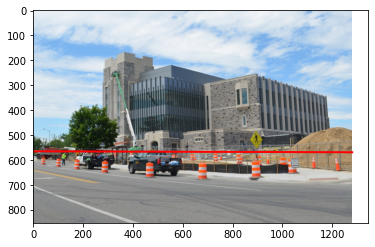

camera parameters: f = -0.5240, u = 0.2373, v = -0.8039
R = [[-0.77532295  0.05418574  0.62923622]
 [-0.28972608  0.85477714 -0.43059824]
 [ 0.56118902  0.51615884  0.64702931]]


In [12]:
%matplotlib inline
# <YOUR IMPLEMENTATION> Get the ground horizon line
horizon_line = get_horizon_line(vpts[:, 0], vpts[:, 1])
# <YOUR IMPLEMENTATION> Plot the ground horizon line
plot_horizon_line(horizon_line, im)

# Part 2
# <YOUR IMPLEMENTATION> Solve for the camera parameters (f, u, v)
f, u, v = get_camera_parameters(vpts)
print(f"camera parameters: f = {f:.4f}, u = {u:.4f}, v = {v:.4f}")

# Part 3
# <YOUR IMPLEMENTATION> Solve for the rotation matrix
R = get_rotation_matrix(f, u, v, vpts)
print(f"R = {R}")


In [13]:
# Part 4
# Record image coordinates for each object and store in map
%matplotlib tk
im = np.asarray(Image.open('metrology.jpg'))
num_vpts = 2
vpts = np.zeros((3, num_vpts))
for i in range(num_vpts):
    print('Getting vanishing point %d' % i)
    # Get at least three lines from user input
    n, lines, centers = get_input_lines(im)
    # <YOUR IMPLEMENTATION> Solve for vanishing point
    vpts[:, i] = get_vanishing_point(lines, centers)
    # Plot the lines and the vanishing point
    # plot_lines_and_vp(im, lines, vpts[:, i])
    # specify the vp
    # print(f"The valishing point {i+1} is {vpts[:, i]}")

horizon_line = get_horizon_line(vpts[:, 0], vpts[:, 1])


Getting vanishing point 0
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Getting vanishing point 1
Set at least 3 lines to compute vanishing point
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input
Click the two endpoints, use the right key to undo, and use the middle key to stop input


Click on the top coordinate of sign
Click on the bottom coordinate of sign
Click on the top coordinate of tractor
Click on the bottom coordinate of tractor
Click on the top coordinate of building
Click on the bottom coordinate of building
0.0197x + -0.9998y + 560.6560 = 0


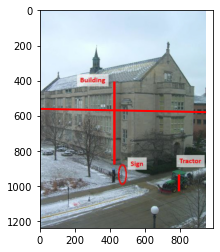

Estimating height of tractor
height obj = 1.2548965969592678
Estimating height of building
height obj = 9.237861349893674


: 

In [ ]:
objects = ('sign', 'tractor', 'building')
coords = dict()
for obj in objects:
    coords[obj] = get_top_and_bottom_coordinates(im, obj)

%matplotlib inline
plot_horizon_line(horizon_line, im)

# <YOUR IMPLEMENTATION> Estimate heights
for obj in objects[1:]:
    print('Estimating height of %s' % obj)
    height = estimate_height(horizon_line, coords['sign'][:, 0], coords['sign'][:, 1], coords[obj][:, 0], coords[obj][:, 1])
    print(f"height obj = {height}")